In [9]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from pyramid.arima import auto_arima

from Sloth.Sloth import Sloth
Sloth = Sloth()

# read and preprocess data
data_index = pd.read_csv("datasets/index.csv")
data_index['start_ind'][0] = 0

# MAKE SURE TO DOWNLOAD "data.csv" LOCALLY FROM http://snap.stanford.edu/seismic/ (too big for Git)
data = pd.read_csv("datasets/data.csv")

/home/jgleason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [58]:
# bin tweets by hour
'''
s_per_hr = 3600       # bin tweets by hour
#s_per_min = 60       # bin tweets by minute 
#s_per_10_min = 360   # bin tweets by 10-minute intervals
retweets = data['relative_time_second'][data_index['start_ind'][tweet_index] + 1:data_index['end_ind'][tweet_index]]
hourly = pd.cut(retweets, range(int(retweets.values[0]), int(retweets.values[len(retweets.values) - 1]) + s_per_hr,s_per_hr))
bin_hourly = retweets.groupby(hourly).agg('count')
#bin_hourly = Sloth.ScaleSeriesMinMax(bin_hourly, -1, 1)[0]
bin_hourly = pd.DataFrame(data = bin_hourly.values, index = range(len(bin_hourly)))
bin_hourly.columns = ['tweet_count']
'''
import os
from datetime import datetime

# write data out to json file for Amazon DeepAR algorithm
with open("data_train.json", "w") as f:
    with open("data_test.json", "w") as f2:
        for tweet_index in range(1):#data_index.shape[0]):
            print(data_index['post_time_day'][tweet_index] * 10 ** 9)
            print(datetime.utcfromtimestamp(int(data_index['post_time_day'][tweet_index] * 10 ** 9)))
            print(tweet_index / data_index.shape[0])
            # bin tweets by hour
            s_per_hr = 3600       # bin tweets by hour
            #s_per_min = 60       # bin tweets by minute 
            #s_per_10_min = 360   # bin tweets by 10-minute intervals
            retweets = data['relative_time_second'][data_index['start_ind'][tweet_index] + 1:data_index['end_ind'][tweet_index]]
            hourly = pd.cut(retweets, range(int(retweets.values[0]), int(retweets.values[len(retweets.values) - 1]) + s_per_hr,s_per_hr))
            bin_hourly = retweets.groupby(hourly).agg('count')
            f.write("{\"start\": \"" + str(int(data_index['post_time_day'][tweet_index] * 10 ** 12)) + "\", \"target\": [")
            for i in range(int(.1 * len(bin_hourly.values))):
                f.write(str(bin_hourly[i]) + ", ")
            f.seek(0, os.SEEK_END)
            f.seek(f.tell() - 2, os.SEEK_SET)
            f.truncate()
            f.write("]}\n")
            f2.write("{\"start\": \"" + str(int(data_index['post_time_day'][tweet_index] * 10 ** 12)) + "\", \"target\": [")
            for j in range(i+1, len(bin_hourly.values)):
                f2.write(str(bin_hourly[i]) + ", ")
            f2.seek(0, os.SEEK_END)
            f2.seek(f2.tell() - 2, os.SEEK_SET)
            f2.truncate()
            f2.write("]}\n")
    f2.close()
f.close()
        

926643518.5189999
1999-05-14 00:58:38
0.0


In [3]:
# function that plots time series data
# parameters:
#     input_data:                input data frame to plot
#     title:                     string to represent time series data, to be used as title / ylabel

def plot_data(input_data, title):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.plot(input_data.index, input_data.values, "k-")
    plt.xlabel("Year")
    plt.ylabel(title)
    plt.title(title)
 
# function that plots time series seasonal decomposition
# parameters:
#     input_data:                input data frame 
#     frequency:                 frequency, or periodicity, of the time series
def plot_seasonal(input_data, *frequency):
    if not frequency:
        result = Sloth.DecomposeSeriesSeasonal(input_data.index, input_data.values)
    else:
        result = Sloth.DecomposeSeriesSeasonal(input_data.index, input_data.values, frequency[0])
    fig = result.plot()
    plt.xlabel("Hour")
    plt.show()

# function that makes a future forecast for time series data
# parameters:
#     train:                     input training data frame
#     test:                      input testing data frame
#     seasonal:                  boolean; whether data has seasonal component
#     seasonal_differencing      period for seasonal differencing

def future_forecast(train, test, seasonal, *seasonal_differencing):
    
    print("DEBUG::the size of test is:")
    print(test.shape)
    
    '''
    if not seasonal_differencing:
        future_forecast = Sloth.PredictSeriesARIMA(train,test.shape[0],seasonal)
    else:
        future_forecast = Sloth.PredictSeriesARIMA(train,test.shape[0],seasonal, seasonal_differencing[0])
    '''
    if not seasonal_differencing:
            stepwise_model = auto_arima(train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=1,
                            start_P=1, start_Q = 1, seasonal=seasonal,
                            d=None, D=0, trace=True,
                            error_action='ignore',  
                            suppress_warnings=False, 
                            stepwise=True)
        # specified seasonal differencing parameter
    else:
        stepwise_model = auto_arima(train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=seasonal_differencing[0],
                            start_P=1, start_Q = 1, seasonal=seasonal,
                            d=None, D=0, trace=True,
                            error_action='ignore',  
                            suppress_warnings=False, 
                            stepwise=True)
    stepwise_model.fit(train)
    future_forecast = stepwise_model.predict(n_periods=test.shape[0])
    #print("DEBUG::Future forecast:")
    #print(future_forecast)

    future_forecast = pd.DataFrame(future_forecast,index = test.index, columns=["Prediction"])
    return future_forecast


# function that plots time series data
# parameters:
#     input_data:                input data frame to plot
#     future_forecast:           future forecast for time series data
#     title:                     string to represent time series data, to be used as title / ylabel
def plot_future_forecast(input_data, test, future_forecast, title):
    plt.subplot(2, 1, 1)
    plt.plot(pd.concat([test,future_forecast],axis=1).index, pd.concat([test,future_forecast],axis=1).values)
    plt.xlabel("data point index")
    plt.title(title)
    plt.subplot(2, 1, 2)
    plt.plot(pd.concat([input_data,future_forecast],axis=1).index, pd.concat([input_data,future_forecast],axis=1).values)
    plt.xlabel("Hour")

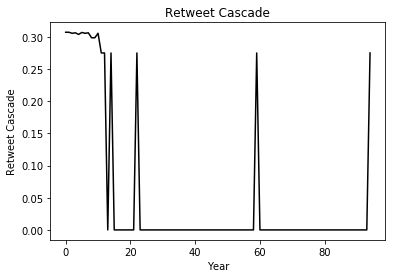

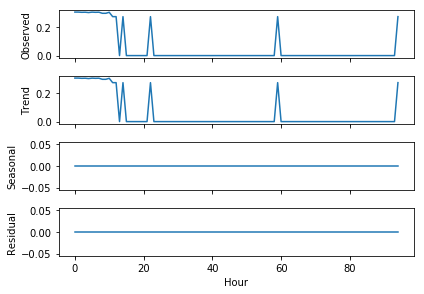

DEBUG::the size of test is:
(76, 1)
Fit ARIMA: order=(1, 1, 1); AIC=-32.763, BIC=-29.202, Fit time=0.132 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-23.971, BIC=-22.190, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-33.752, BIC=-31.081, Fit time=0.123 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-31.167, BIC=-28.496, Fit time=0.097 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-33.273, BIC=-29.712, Fit time=0.129 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-31.302, BIC=-26.851, Fit time=0.161 seconds
Total fit time: 0.662 seconds


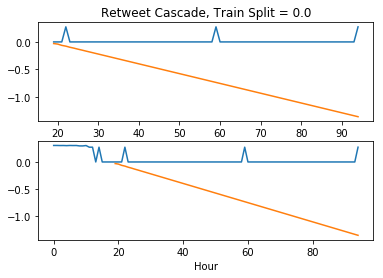

DEBUG::the size of test is:
(57, 1)
Fit ARIMA: order=(1, 1, 1); AIC=-75.557, BIC=-69.113, Fit time=0.100 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-60.713, BIC=-57.491, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-75.485, BIC=-70.653, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-75.111, BIC=-70.278, Fit time=0.099 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-73.769, BIC=-65.715, Fit time=0.176 seconds
Fit ARIMA: order=(1, 1, 2); AIC=-73.995, BIC=-65.941, Fit time=0.208 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-72.072, BIC=-62.407, Fit time=0.277 seconds
Total fit time: 0.929 seconds


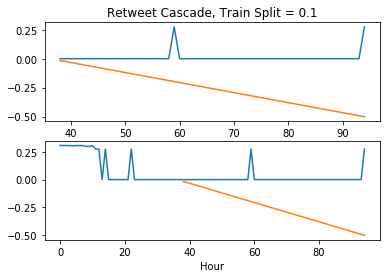

DEBUG::the size of test is:
(38, 1)
Fit ARIMA: order=(1, 1, 1); AIC=-140.949, BIC=-132.848, Fit time=0.107 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-117.023, BIC=-112.972, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-140.226, BIC=-134.150, Fit time=0.046 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-138.728, BIC=-132.652, Fit time=0.064 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-139.352, BIC=-129.226, Fit time=0.233 seconds
Fit ARIMA: order=(1, 1, 2); AIC=-140.026, BIC=-129.900, Fit time=0.240 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-138.145, BIC=-125.993, Fit time=0.367 seconds
Total fit time: 1.067 seconds


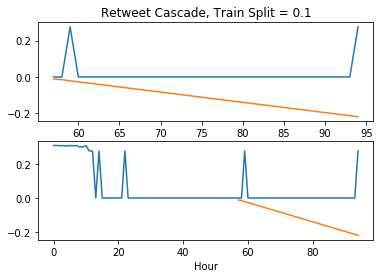

DEBUG::the size of test is:
(19, 1)
Fit ARIMA: order=(1, 1, 1); AIC=-185.816, BIC=-176.546, Fit time=0.187 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-154.663, BIC=-150.029, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-182.312, BIC=-175.360, Fit time=0.097 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-184.880, BIC=-177.927, Fit time=0.104 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-183.951, BIC=-172.364, Fit time=0.228 seconds
Fit ARIMA: order=(1, 1, 2); AIC=-183.958, BIC=-172.370, Fit time=0.277 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-181.977, BIC=-168.072, Fit time=0.371 seconds
Total fit time: 1.285 seconds


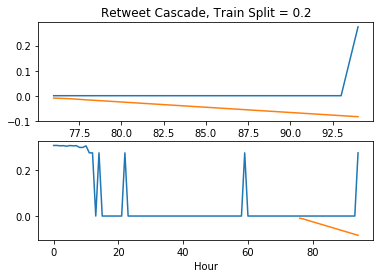

In [6]:
from scipy import stats
bin_hourly = retweets.groupby(hourly).agg('count')
#bin_hourly = Sloth.ScaleSeriesMinMax(bin_hourly, -1, 1)[0]
bin_hourly = pd.DataFrame(data = bin_hourly.values, index = range(len(bin_hourly)))
bin_hourly.columns = ['tweet_count']

# tried all of these transformations - none changed overall ARIMA prediction
#bin_hourly['tweet_count'] = Sloth.ScaleSeriesMeanVariance(bin_hourly['tweet_count'])[0]
#bin_hourly['tweet_count'] = Sloth.ScaleSeriesMinMax(bin_hourly['tweet_count'], 0, 1)[0]
#bin_hourly['tweet_count'] = [math.log(i) if i > 0 else 0 for i in bin_hourly['tweet_count']]

# Box Cox transformation
series = bin_hourly['tweet_count']
min_value = min(series)
if min_value <= 0:
    # scale series to positive values only
    series = [i + abs(min_value) + 1 for i in series]
transformed, lam = stats.boxcox(series)
bin_hourly['tweet_count'] = transformed
    
plot_data(bin_hourly, "Retweet Cascade")
plot_seasonal(bin_hourly)

# range between .2 -> .8 train / test split
for i in [i * 0.2 for i in range(1, 5)]:
    train_split = int(i * len(bin_hourly))
    train = bin_hourly[:train_split]
    test = bin_hourly[train_split:]
    future_forecast_tweets = future_forecast(train, test, False)
    plot_future_forecast(bin_hourly, test, future_forecast_tweets, 'Retweet Cascade, Train Split = %.1f' % (0.2 * i))
    plt.show()

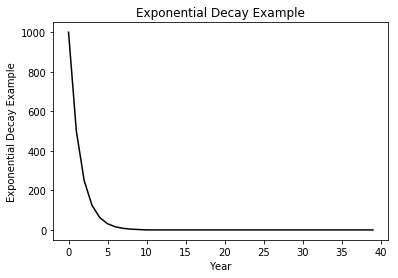

DEBUG::the size of test is:
(30, 1)
Fit ARIMA: order=(1, 2, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0); AIC=85.721, BIC=85.613, Fit time=0.011 seconds


/home/jgleason/.local/lib/python3.5/site-packages/statsmodels/tsa/ar_model.py:765: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + (1 + self.df_model) * np.log(nobs)/nobs
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/jgleason/.local/lib/python3.5/site

Fit ARIMA: order=(1, 2, 0); AIC=83.811, BIC=83.648, Fit time=0.200 seconds
Fit ARIMA: order=(0, 2, 1); AIC=84.227, BIC=84.064, Fit time=0.088 seconds


/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

Fit ARIMA: order=(2, 2, 0); AIC=98.230, BIC=98.014, Fit time=0.293 seconds
Fit ARIMA: order=(2, 2, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.005 seconds


/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

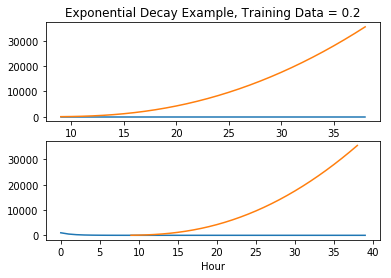

DEBUG::the size of test is:
(20, 1)
Fit ARIMA: order=(1, 2, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0); AIC=193.400, BIC=195.066, Fit time=0.023 seconds
Fit ARIMA: order=(1, 2, 0); AIC=178.171, BIC=180.671, Fit time=0.123 seconds


/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

Fit ARIMA: order=(0, 2, 1); AIC=184.214, BIC=186.714, Fit time=0.139 seconds


/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

Fit ARIMA: order=(2, 2, 0); AIC=170.893, BIC=174.225, Fit time=0.466 seconds
Fit ARIMA: order=(2, 2, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 2, 1); AIC=nan, BIC=nan, Fit time=nan seconds


/home/jgleason/.local/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/home/jgleason/.local/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/jgleason/.local/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/jgleason/.local/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/home/jgleason/.local/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/jgleason/.local/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/jgleason/.local/lib/

Fit ARIMA: order=(3, 2, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.113 seconds


/home/jgleason/.local/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


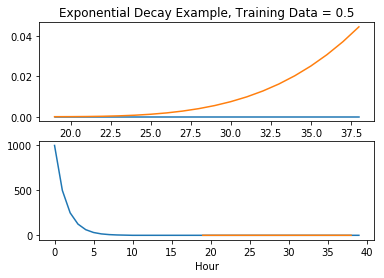

DEBUG::the size of test is:
(10, 1)
Fit ARIMA: order=(1, 2, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0); AIC=294.382, BIC=296.974, Fit time=0.014 seconds
Fit ARIMA: order=(1, 2, 0); AIC=265.668, BIC=269.555, Fit time=0.092 seconds
Fit ARIMA: order=(0, 2, 1); AIC=277.321, BIC=281.208, Fit time=0.062 seconds


/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

Fit ARIMA: order=(2, 2, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.414 seconds


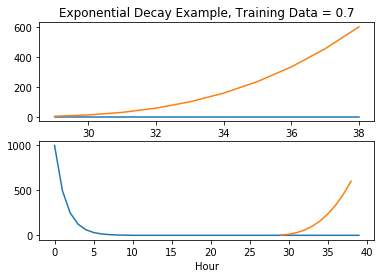

In [11]:
# test simple exponential decay example for sanity check
import math

X_train = [1000*0.5**i for i in range(10)]
X_test = [0 for i in range(10)]
data = X_train + X_test * 3
#data = Sloth.ScaleSeriesMeanVariance(data)[0]
#data = [math.log(i) if i > 0 else 0 for i in data]
data = pd.DataFrame(data)
plot_data(data, "Exponential Decay Example")
plt.show()
for i in range(9,30,10):
    X_train = data[:i]
    X_test = data[i+1:]
    X_test.index = [j + len(X_train) for j in range(len(X_test))]

    future_forecast_exp = future_forecast(X_train, X_test, False)
    plot_future_forecast(data, X_test, future_forecast_exp, 'Exponential Decay Example, Training Data = %.1f' % (i/len(data)))
    plt.show()

In [49]:
# create JSON formatted sunspot data for initial DeepAR testing
sunspots = pd.read_csv("/data/home/jgleason/D3m/datasets/seed_datasets_current/56_sunspots/56_sunspots_dataset/tables/learningData.csv", index_col = 0)
sunspots = sunspots['sunspot.month'].dropna()
#index = [i for i in range(1700, 1700 + sunspots.shape[0])]
print(sunspots.head())
print(sunspots[2580])


with open("sunspots_train.json", "w") as f:
    f.write("{\"start\": \"1749\", \"target\": [")
    for i in range(49,2581):
        f.write(str(sunspots[i]) + ", ")
    f.seek(0, os.SEEK_END)
    f.seek(f.tell() - 2, os.SEEK_SET)
    f.truncate()
    f.write("]}\n")
    with open("sunspots_test.json", "w") as f2:
        f2.write("{\"start\": \"1960\", \"target\": [")
        for i in range(2581,2869):
            f2.write(str(sunspots[i]) + ", ")
        f2.seek(0, os.SEEK_END)
        f2.seek(f2.tell() - 2, os.SEEK_SET)
        f2.truncate()
        f2.write("]}\n")
f.close()
f2.close()


d3mIndex
49    58.0
50    62.6
51    70.0
52    55.7
53    85.0
Name: sunspot.month, dtype: float64
125.0
